<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/neural%20network/00_NN_Recommender_system_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf
    print("Versión de TensorFlow:", tf.__version__)
    print("Dispositivos disponibles:", tf.config.list_physical_devices())

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    path_workspace = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')
else:
    print("El código se está ejecutando en un entorno local.")
    path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path


sys.path.append(path_workspace)

El código se está ejecutando en un entorno local.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import Utils.utils as util
import matplotlib.pyplot as plt


from keras import backend as K
from keras.models import Model
from IPython.display import SVG
from wordcloud import WordCloud
from keras.callbacks import EarlyStopping
# from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.layers import Dense,Dropout,Flatten,Embedding,BatchNormalization,Concatenate,Add,Concatenate,Dot,Input,dot,concatenate




# # Configure visualisations
# %matplotlib inline
# mpl.style.use( 'ggplot' )
# plt.style.use('fivethirtyeight')
# sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [3]:
# dataFrame_onehot_encode = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs_onehot_encode.csv', sep=',')

# dataFrame_onehot_encode.head()

In [4]:
dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')
print(dataFrame_without_ohe.shape)
dataFrame_without_ohe.head()

C:\Users\jaime\AppData\Local\Temp\ipykernel_23844\1541070402.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
0,1,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1147880044,5.0
1,3,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1439474476,5.0
2,4,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1573938898,4.0
3,5,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,830786155,4.0
4,7,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,835444730,4.0


In [7]:
# Filtrar usuarios con al menos x calificaciones
min_n_ratings=50
df_aux = dataFrame_without_ohe.copy()
df_filtered_by_ratings_counts = df_aux.groupby('userId').filter(lambda x: len(x) >= min_n_ratings)
print(df_filtered_by_ratings_counts.shape)
# print(df_filtered['userId'].value_counts().sort_values(ascending=False))
# print(df_filtered['userId'].value_counts().sort_values(ascending=True))
df_filtered_by_ratings_counts.head()


(23107403, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
0,1,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1147880044,5.0
1,3,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1439474476,5.0
2,4,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1573938898,4.0
3,5,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,830786155,4.0
5,8,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,890489713,5.0


In [8]:
dataFrame = df_filtered_by_ratings_counts.copy()
# dataFrame = dataFrame_onehot_encode.copy()

In [9]:
dataFrame = dataFrame.sample(n=200000, random_state=42)
df = dataFrame.copy()
print(df.shape)
df.head()

(200000, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
3247187,65707,4306,NaN,"animation, oscar (best animated feature), comp...",Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,1429178074,4.0
1103377,1579,364,NaN,"animated, animation, oscar (best animated feat...","Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,844449457,3.0
13549468,158132,908,NaN,"mistaken identity, imdb top 250, espionage, sp...",North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,1072120915,4.5
1281291,112347,480,NaN,"adventure, big budget, spielberg, dinosaurs, s...",Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,848516510,3.0
6000055,58015,5669,NaN,"documentary, guns, violence, canada, social co...",Bowling for Columbine (2002),Documentary,1231107233,2.5


In [10]:
# import pandas as pd

# # Supongamos que 'df' es tu DataFrame que contiene las columnas 'userId' y 'movieId'

# # Crear un diccionario para almacenar las ocurrencias de cada par de valores
# ocurrencias = {}

# # Iterar sobre el DataFrame para contar las ocurrencias de cada par de valores
# for index, row in df.iterrows():
#     userId = row['userId']
#     movieId = row['movieId']
#     par_valores = (userId, movieId)
#     ocurrencias[par_valores] = ocurrencias.get(par_valores, 0) + 1

# # Imprimir todas las ocurrencias encontradas
# for par_valores, frecuencia in ocurrencias.items():
#     print(f"El par de valores {par_valores} se repite {frecuencia} veces.")


In [11]:
df = df[~df.duplicated(subset=['userId', 'movieId'], keep='first')]

In [12]:
df.shape

(200000, 8)

## Explore dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 3247187 to 7124801
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       200000 non-null  int64  
 1   movieId      200000 non-null  int64  
 2   tag_by_user  1718 non-null    object 
 3   tag_genome   197176 non-null  object 
 4   title        200000 non-null  object 
 5   genres       200000 non-null  object 
 6   timestamp    200000 non-null  int64  
 7   rating       200000 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 13.7+ MB


In [14]:
# Valores nulos
print(f"Valores nulos para la columna userId: {df['userId'].isnull().sum()}")
print(f"Valores nulos para la columna rating: {df['rating'].isnull().sum()}")
print(f"Valores nulos para la columna movieId: {df['movieId'].isnull().sum()}")

Valores nulos para la columna userId: 0
Valores nulos para la columna rating: 0
Valores nulos para la columna movieId: 0


In [15]:
# Se cuenta los valores unicos de rating
df['rating'].value_counts()

4.0    53052
3.0    39199
5.0    27380
3.5    26330
4.5    17696
2.0    13314
2.5    10373
1.0     6256
1.5     3272
0.5     3128
Name: rating, dtype: int64

In [16]:
# Se cuenta los valores unicos de usuarios
df['userId'].value_counts()

72315     281
80974      95
20055      72
137293     67
33844      58
         ... 
47003       1
15366       1
113186      1
23181       1
122248      1
Name: userId, Length: 69717, dtype: int64

In [17]:
# Se cuenta los valores unicos de peliculas
df['movieId'].value_counts()

356       576
318       557
593       536
296       530
2571      527
         ... 
57848       1
91474       1
71542       1
129723      1
27416       1
Name: movieId, Length: 13492, dtype: int64

In [18]:
rango_valores = df['rating'].describe()['min'], df['rating'].describe()['max']
print("Rango de valores cd rating:", rango_valores)

Rango de valores cd rating: (0.5, 5.0)


In [19]:
#promedio de calificaciones agrupado por titulos
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Boy Named Charlie Brown, A (1969)                5.0
Good Boys (2019)                                 5.0
Fireworks (1947)                                 5.0
Guy Named Joe, A (1943)                          5.0
Kingsglaive: Final Fantasy XV (2016)             5.0
O Lucky Man! (1973)                              5.0
Burmese Harp, The (Biruma no tategoto) (1956)    5.0
There Once Was a Dog (1982)                      5.0
Bustin' Down the Door (2009)                     5.0
The... Beautiful Country (1977)                  5.0
Name: rating, dtype: float64

In [20]:
# Cuantos generos distintos hay y cuantqas peliculas clasificadas con ese genero entre otros.
if 'genres' in df.columns:
    genres = {}
    def find_genres():
        for genre in df['genres']:
            words = genre.split('|')
            for word in words:
                genres[word] = genres.get(word, 0) + 1
    find_genres()
    # genres['None'] = genres.pop('(no genres listed)')
    genres



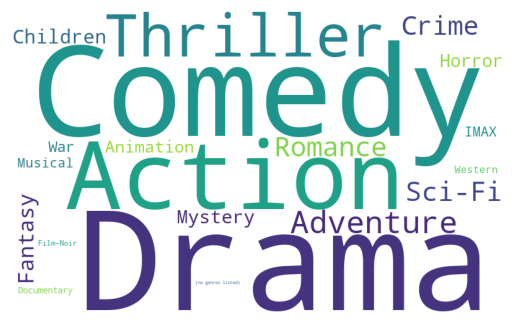

In [21]:
# Nube de palabras para los generos
if 'genres' in df.columns:
    wordcloud = WordCloud(width=800, height=500, background_color = 'white',
                        min_font_size=6, contour_color='black', contour_width=2).generate_from_frequencies(genres)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [22]:
#Peliculas más puntuadas
df_n_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),3.988715,576
"Shawshank Redemption, The (1994)",4.412926,557
"Silence of the Lambs, The (1991)",4.191231,536
Pulp Fiction (1994),4.317925,530
"Matrix, The (1999)",4.188805,527
Star Wars: Episode IV - A New Hope (1977),4.027723,505
Jurassic Park (1993),3.676734,447
Terminator 2: Judgment Day (1991),3.938341,446
Star Wars: Episode V - The Empire Strikes Back (1980),4.152425,433


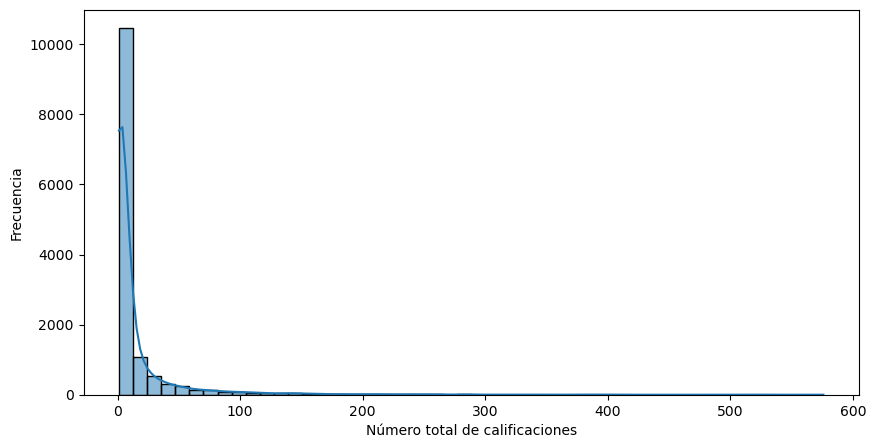

In [23]:
# histograma de la distribución de frecuencia del número total de calificaciones en el DataFrame
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['total ratings'], bins=50, kde=True)  # kde=True incluye la estimación de densidad kernel
plt.xlabel('Número total de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [24]:
# Calificaciones promedio más altas en función de la columna 'mean ratings'.
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"Boy Named Charlie Brown, A (1969)",5.0,1
Good Boys (2019),5.0,1
Fireworks (1947),5.0,1
"Guy Named Joe, A (1943)",5.0,1
Kingsglaive: Final Fantasy XV (2016),5.0,1
O Lucky Man! (1973),5.0,1
"Burmese Harp, The (Biruma no tategoto) (1956)",5.0,1
There Once Was a Dog (1982),5.0,1
Bustin' Down the Door (2009),5.0,1


In [25]:
print('Nº total de usuarios que han valorado con 5,0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Nº total de usuarios individuales que han valorado con 5,0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5)
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Nº total de usuarios que han valorado con 5,0 :  385 

Nº total de usuarios individuales que han valorado con 5,0 :  369


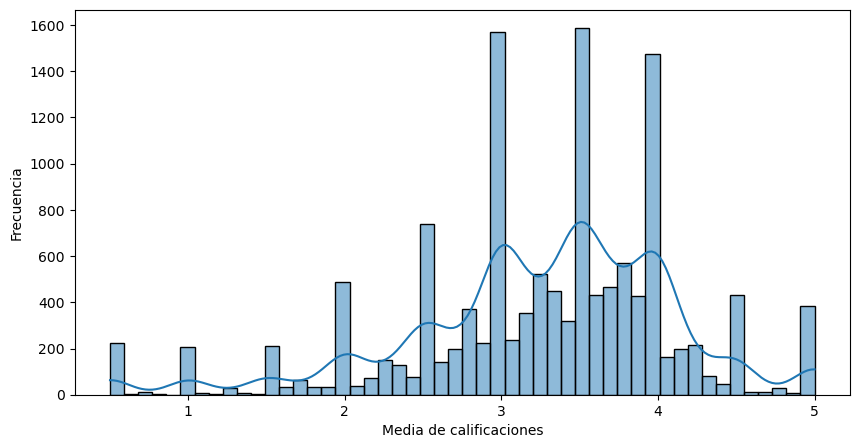

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['mean ratings'], bins=50, kde=True)
plt.xlabel('Media de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

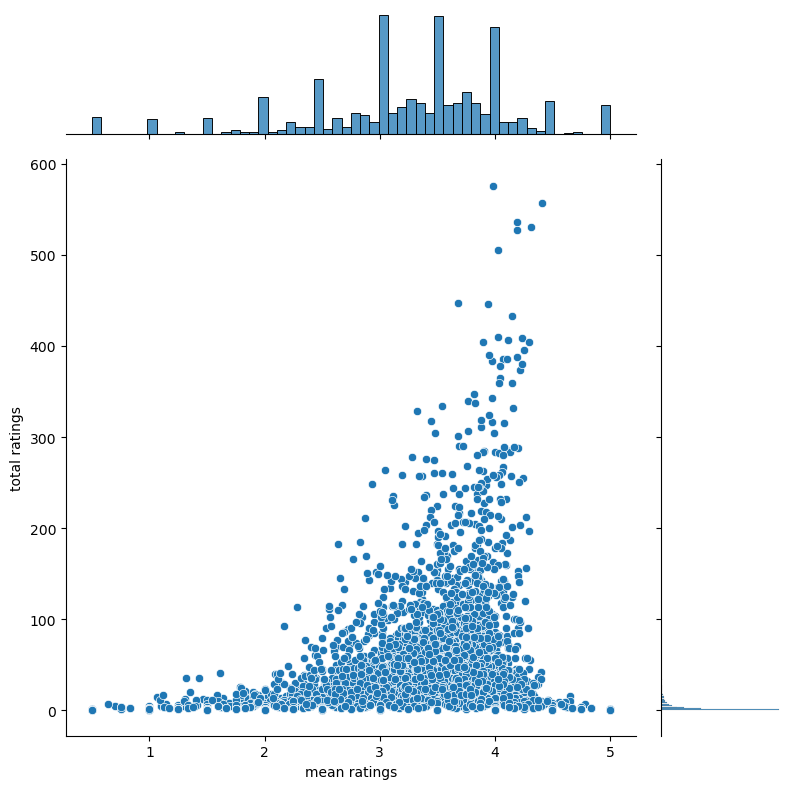

In [27]:
# Mean Ratings vs Total Number of Ratings
sns.jointplot(x='mean ratings', y='total ratings', data=df_n_ratings, height=8, ratio=4)


## MODELS

In [28]:
df.head(3)

,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
3247187,65707,4306,NaN,"animation, oscar (best animated feature), comp...",Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,1429178074,4.0
1103377,1579,364,NaN,"animated, animation, oscar (best animated feat...","Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,844449457,3.0
13549468,158132,908,NaN,"mistaken identity, imdb top 250, espionage, sp...",North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,1072120915,4.5


In [29]:
df_aux = df.copy()
if 'genres' not in df.columns:
    columnas_deseadas = [col for col in df.columns if col not in ['tag_by_user', 'tag_genome', 'title', 'timestamp']]
    df_aux = df.loc[:, columnas_deseadas]
    print(df_aux.head())

In [30]:

# La asignación de índices únicos y la posterior división del DataFrame en conjuntos de entrenamiento y
# prueba pueden ser necesarias por varias razones en el contexto de modelos de recomendación y
# aprendizaje automático en general:

# Índices numéricos: Algunos algoritmos y modelos de aprendizaje automático requieren que las
# entradas sean números enteros. Al asignar índices únicos a los usuarios y películas,
# se asegura de que cada entidad esté representada por un identificador numérico único,
# lo que facilita el procesamiento por parte de los modelos.

# Consistencia en los datos de entrada: Al asignar índices únicos y transformar los datos originales,
# se crea una representación consistente y única para cada usuario y película en el conjunto de datos.
# Esto facilita el manejo y la interpretación de los datos durante el preprocesamiento y el entrenamiento
# del modelo.

# Reproducibilidad: La división aleatoria del DataFrame en conjuntos de entrenamiento y
# prueba utilizando np.random.rand() con una semilla (random_state) proporciona reproducibilidad.
# Esto significa que si vuelves a ejecutar el código con la misma semilla, obtendrás la misma
# división de datos, lo que es útil para comparar resultados y depurar el código.

# Evaluación del modelo: La división en conjuntos de entrenamiento y prueba es esencial para
# evaluar el rendimiento del modelo. El conjunto de entrenamiento se utiliza para entrenar el modelo,
# mientras que el conjunto de prueba se reserva para evaluar su rendimiento en datos no vistos.

# En resumen, estas operaciones son prácticas comunes en el preprocesamiento de datos para modelos
# de aprendizaje automático, especialmente cuando se trata de conjuntos de datos que contienen
# variables categóricas o identificadores que deben ser representados de manera numérica y
# cuando se busca garantizar la consistencia y la reproducibilidad en el procesamiento de datos.


# userId	movieId	timestamp_rt	tag_by_user	timestamp_tags	gen_tag	title	genres	tagId	relevance	rating
# df_aux = df_aux[['userId', 'movieId','rating']]

# Crear diccionarios de asignación de índices únicos
user_unique_ids = df_aux['userId'].unique()
movie_unique_ids = df_aux['movieId'].unique()

userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# Aplicar la asignación de índices únicos al DataFrame
df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# Dividir dataset en entrenamiento y test
if 'genres' in df.columns:
    X = df_aux[['userId', 'movieId', 'genres']]  # UserId y movieId
    Y = df_aux['rating']                # rating
else:
    df_except_last = df.iloc[:, :-1]
    X = df_aux.iloc[:, :-1]
    Y = df_aux['rating']             


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Resetear los índices de x_train y x_test
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

n_genres = 19
print(f'Usuarios unicos: {len(user_unique_ids)} y peliculas unicas {len(movie_unique_ids)}')
print(x_train.shape , x_test.shape)

Usuarios unicos: 69717 y peliculas unicas 13492
(160000, 3) (40000, 3)


In [31]:




# # Dividir dataset en entrenamiento y test
# x_train, x_test, y_train, y_test = train_test_split(df_aux[['userId', 'movieId', 'genres']], df_aux['rating'], test_size=0.2, random_state=42)

# # Resetear los índices de x_train y x_test
# x_train.reset_index(drop=True, inplace=True)
# x_test.reset_index(drop=True, inplace=True)

In [32]:
x_train

,userId,movieId,genres
0,62053,405,Comedy|Crime|Drama|Thriller
1,39526,150,Action|Sci-Fi|Thriller|IMAX
2,28332,3538,Crime|Drama
3,50719,111,Thriller
4,2770,2919,Drama|Horror|Thriller
...,...,...,...
159995,54991,763,Action|Adventure|Drama|Fantasy
159996,20863,4256,Thriller
159997,57760,6541,Crime|Mystery
159998,12781,653,Action|Romance|War|Western


In [33]:
y_train

42608       5.0
6890265     4.0
21039149    4.5
1217956     4.0
22231538    2.5
           ... 
3744488     3.0
5587199     1.5
24452459    5.0
18344917    1.5
2068693     4.0
Name: rating, Length: 160000, dtype: float64

### Definicicón de parametros

In [34]:
# Definición del número de factores latentes
n_latent_factors = 10
# learning_rate = 5e-4
lr = 1e-3
#Función de perdida
loss_function = 'mse'
#Bartch
batch_size = 128
#Epoch
epochs = 150
#Paciencia early stopping
pte = 3

In [35]:
es = EarlyStopping(monitor="val_loss",
                   mode="min",
                   verbose=1,
                   patience=pte)

In [36]:
# Deprecated
# def train_model(model):
#     # Entrenar el modelo y obtener el objeto history
#     history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train,
#                         batch_size= batch_size, epochs=epochs, verbose= 1,
#                         validation_data=([x_test['userId'], x_test['movieId']], y_test),
#                         callbacks=[es])
#     return history

In [37]:
def train_model(model, x=None, y=None, x_test=None, y_test=None):
    # Definir los datos de entrada si no se proporcionan
    if x is None:
        x = [x_train['userId'], x_train['movieId']]
    if y is None:
        y = y_train
    if x_test is None:
        x_test = [x_test['userId'], x_test['movieId']] if x_test is not None else None  # Corrección aquí
    if y_test is None:
        y_test = y_test
    
    # Entrenar el modelo y obtener el objeto history
    history = model.fit(x=x, y=y,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[es])
    return history


In [38]:
#Deprecated no tiene sentido mostrar el accuracy en modelos de regrsión
# def plot_loss(history):
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']

#     fig, ax1 = plt.subplots(figsize=(10, 8))

#     color = 'tab:red'
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Loss', color=color)
#     ax1.plot(loss, 'r--', label='Training Loss')
#     ax1.plot(val_loss, 'b-', label='Validation Loss')
#     ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()
#     color = 'tab:green'
#     ax2.set_ylabel('Accuracy', color=color)
#     ax2.plot(accuracy, 'g-.', label='Training Accuracy')
#     ax2.plot(val_accuracy, 'y:', label='Validation Accuracy')
#     ax2.tick_params(axis='y', labelcolor=color)

#     # Añadir leyendas
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     fig.tight_layout()
#     plt.title('Model Loss and Accuracy')
#     plt.show()


def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax1 = plt.subplots(figsize=(10, 8))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss, 'r--', label='Training Loss')
    ax1.plot(val_loss, 'b-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Añadir leyendas
    ax1.legend(loc='upper left')

    fig.tight_layout()
    plt.title('Model Loss and Accuracy')
    plt.show()

### Arquitectura 1

In [39]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [40]:
# Obtención del número único de usuarios y películas en el conjunto de datos de calificaciones
n_users, n_movies = len(df['userId'].unique()), len(df['movieId'].unique())

# Definición de la entrada del usuario
user_input = Input(shape=(1,), name='User_Input')

# Creación de la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users, output_dim=n_latent_factors, input_length=1,
                            name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)

# Definición de la entrada de la película
movie_input = Input(shape=(1,), name='Movie_Input')

# Creación de la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies, output_dim=n_latent_factors, input_length=1,
                             name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)

# Combinación de los vectores de usuario y película mediante el producto punto
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)

# Creación del modelo utilizando Model API de Keras
model_a1 = Model([user_input, movie_input], merged_vectors)

model_a1.summary()
# Visualizar el modelo de Keras en formato DOT y luego lo convierte a formato SVG para mostrarlo
# SVG(model_to_dot( model_a1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#Compilar modelo SGD,Adagrad,Adadelta,RMSprop
model_a1.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        697170      ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 10)        134920      ['Movie_Input[0][0]']            
                                                                                              

### Arquitectura 2

In [41]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [42]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='user_input', dtype='int64')

# Crear la capa de embedding para usuarios
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # Aplanar la salida de la capa de embedding
user_vec = Dropout(0.40)(user_vec)  # Aplicar Dropout para regularización

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')

# Crear la capa de embedding para películas
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)  # Aplanar la salida de la capa de embedding
movie_vec = Dropout(0.40)(movie_vec)  # Aplicar Dropout para regularización

# Calcular la similitud entre los vectores de usuario y película mediante el producto punto
similarity = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

# Definir una capa de red neuronal para procesar la similitud calculada
nn_inp = Dense(96, activation='relu')(similarity)
nn_inp = Dropout(0.4)(nn_inp)  # Aplicar Dropout para regularización
# nn_inp = BatchNormalization()(nn_inp)  # Normalización por lotes (comentada, opcional)
nn_inp = Dense(1, activation='relu')(nn_inp)

# Crear el modelo utilizando Model API de Keras
model_a2 = Model([user_input, movie_input], nn_inp)
model_a2.summary()  # Mostrar resumen del modelo en términos de parámetros y capas

# Compilar el modelo con la función de pérdida y el optimizador especificados
model_a2.compile(loss=loss_function, optimizer= Adam(learning_rate=lr) )


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        697170      ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        134920      ['movie_input[0][0]']            
                                                                                              

### Arquitectura 3

In [43]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [44]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='User_Input')

# Crear la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users+1, output_dim=n_latent_factors, input_length=1, name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)  # Aplanar la salida de la capa de embedding

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='Movie_input')

# Crear la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies+1, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)  # Aplanar la salida de la capa de embedding

# Concatenar los vectores de usuario y película
merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')

# Capa densa con 100 unidades y función de activación ReLU
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)

# Aplicar Dropout para regularización
dense_layer_3 = Dropout(0.5)(dense_layer_1)

# Capa densa de salida con 1 unidad
dense_layer_2 = Dense(1)(dense_layer_3)

# Crear el modelo utilizando Model API de Keras
model_a3 = Model([user_input, movie_input], dense_layer_2)

# Compilar el modelo con la función de pérdida, el optimizador y métricas especificados
model_a3.compile(loss=loss_function, optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
model_a3.summary()  # Mostrar resumen del modelo en términos de parámetros y capas


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        697180      ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 10)        134930      ['Movie_input[0][0]']            
                                                                                              

### Arquitectura 4

In [45]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [46]:
# Definición de la entrada del usuario (user_input)
user_input = Input(shape=[1], name='user')  # Capa de entrada para la información del usuario.
# print(f"User Input Shape: {user_input.shape}")

# Creación de la capa de embedding para usuarios (user_embedding)
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
# La capa de embedding asigna a cada usuario un vector en el espacio de factores latentes.
# print(f"User Embedding Shape: {user_embedding.shape}")

# Aplanamiento de la capa de embedding para usuarios (user_vec)
user_vec = Flatten(name='flatten_users')(user_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa al usuario en el espacio de factores latentes.
# print(f"Flattened User Vector Shape: {user_vec.shape}")

# Definición de la entrada de la película (movie_input)
movie_input = Input(shape=[1], name='movie')  # Capa de entrada para la información de la película.
# print(f"Movie Input Shape: {movie_input.shape}")

# Creación de la capa de embedding para películas (movie_embedding)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
# La capa de embedding asigna a cada película un vector en el espacio de factores latentes.
# print(f"Movie Embedding Shape: {movie_embedding.shape}")

# Aplanamiento de la capa de embedding para películas (movie_vec)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa la película en el espacio de factores latentes.
# print(f"Flattened Movie Vector Shape: {movie_vec.shape}")

# Cálculo del producto punto entre los vectores de película y usuario (product)
product = dot([movie_vec, user_vec], axes=1)
# El modelo calcula el producto punto entre los vectores de película y usuario para predecir las calificaciones.
# print(f"Product Shape: {product.shape}")

# Definición del modelo (model)
model_a4 = Model(inputs=[user_input, movie_input], outputs=product)

# Compilación del modelo con la función de pérdida y optimizador
model_a4.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        134930      ['movie[0][0]']                  
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        697180      ['user[0][0]']                   
                                                                                              

### Arquitectura 5

In [47]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [48]:
# Definir la entrada del usuario y su embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

# Definir la entrada de la película y su embedding
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenar los embeddings de usuario y película
concatenated = concatenate([user_vec, movie_vec], name='Concatenation')

# Añadir capas Dense con activación ReLU
dense_layer1 = Dense(128, activation='relu')(concatenated)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(32, activation='relu')(dense_layer2)

# Capa de salida con activación lineal
output = Dense(1, activation='linear')(dense_layer3)

# Crear el modelo con métrica R cuadrado
model_a5 = Model(inputs=[user_input, movie_input], outputs=output)

# Compilación del modelo con la función de pérdida y optimizador
model_a5.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        697180      ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        134930      ['movie[0][0]']                  
                                                                                              

### Arquitectura 6

In [49]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [50]:
user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)

user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)

user_bias = Embedding(n_users, 1, name="user_bias")(user_input)

item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)
item_bias = Embedding(n_movies, 1, name="item_bias")(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

dot_user_item = Dot(name="dot", axes=1)([user_vector, item_vector])
output = Add(name="add")([dot_user_item, user_bias, item_bias])
output = Flatten(name="flat")(output)

model_a6 = Model([user_input, item_input], output, name="model_x")

model_a6.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a6.summary()

Model: "model_x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        697170      ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        134920      ['item_id[0][0]']                
                                                                                            

In [51]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir las métricas personalizadas en TensorFlow/Keras
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def pearson_corr(y_true, y_pred):
    # Convertir y_pred a tipo float64
    y_pred = y_pred.astype(np.float64)
    # Calcular la correlación de Pearson
    return tfp.stats.correlation(y_true, y_pred, sample_axis=0, event_axis=1)


In [94]:
def calcular_metricas(model, x_test, y_test):
    # Obtener predicciones del modelo
    predictions = model.predict(x_test)
    
    # Aplanar predicciones
    predictions = predictions.ravel()
    
    # Calcular métricas
    rmse_val = rmse(y_test, predictions)
    mae_val = mae(y_test, predictions)
    mape_val = mape(y_test, predictions)
    mse_val = mse(y_test, predictions)
    r2_val = r2_score(y_test, predictions)
    # pearson_corr_val = pearson_corr(y_test, predictions)
    
    # Imprimir métricas
    print("RMSE:", rmse_val.numpy())
    print("MAE:", mae_val.numpy())
    print("MSE:", mse_val.numpy())
    print("R2 Score:", r2_val)
    print(f"MAPE: {(mape_val.numpy())/100} \nMAPE %: {mape_val.numpy()} %")
    # print("Pearson Correlation:", pearson_corr_val)

In [53]:
# from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

# y_pred = model_a6.predict([x_test['userId'], x_test['movieId']])
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

# rmse = np.sqrt(mse)
# print(f'Root Mean Squared Error: {rmse}')

# # Calcular R cuadrado
# r2 = r2_score(y_test, y_pred)
# print(f'R Squared: {r2}')

# from scipy.stats import pearsonr

# # Calcular la correlación de Pearson
# correlation, _ = pearsonr(np.array(y_test), y_pred.flatten())
# print(f'Pearson Correlation: {correlation}')

375/375 [==============================] - 1s 1ms/step:

Indica que se realizaron 375 iteraciones o pasos durante el proceso de evaluación, y cada iteración tardó aproximadamente 1 milisegundo.

1. Mean Squared Error (MSE): 3.0927204499125063:

El MSE es una medida del promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales. En este caso, un MSE de 3.09 indica que las predicciones tienden a desviarse, en promedio, al cuadrado de 3.09 unidades de la verdad.

2. Root Mean Squared Error (RMSE): 1.7586132178260534:

El RMSE es simplemente la raíz cuadrada del MSE. En este caso, un RMSE de 1.76 significa que, en promedio, las predicciones tienden a desviarse alrededor de 1.76 unidades de la verdad.

3. R Squared: -1.8672807452362834:

El R cuadrado (R2) es una medida de la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor negativo de R2 no es común y sugiere que el modelo no es apropiado para estos datos, ya que es peor que simplemente predecir la media de los datos observados.

4. Pearson Correlation: 0.3082110202566218:

La correlación de Pearson es una medida de la fuerza y dirección de la relación lineal entre dos variables. Un valor de 0.31 indica una correlación positiva débil. Sin embargo, la correlación por sí sola no proporciona una imagen completa y debe interpretarse junto con otras métricas.

En general, estas métricas sugieren que el modelo puede no estar funcionando tan bien en tus datos de prueba. El MSE y RMSE indican el error absoluto promedio, y un R2 negativo sugiere que el modelo no está explicando la varianza de los datos de manera efectiva. La correlación de Pearson, aunque positiva, es relativamente baja. Puedes considerar ajustar tu modelo o explorar otras métricas y técnicas para mejorar su rendimiento.

In [54]:
# def calculate_metrics(y_true, y_pred, k=5):
#     """
#     Calcula métricas de evaluación para un modelo de recomendación.

#     Parámetros:
#     - y_true: Valores reales de calificación.
#     - y_pred: Predicciones del modelo.
#     - k: Número de elementos recomendados por usuario.

#     Devuelve:
#     - precision: Precisión.
#     - recall: Recall.
#     - mrr: Mean Reciprocal Rank.
#     - map: Mean Average Precision.
#     - coverage: Cobertura.
#     """
    
#     # Obtener índices de las principales predicciones para cada usuario
#     top_k_indices = np.argsort(y_pred, axis=1)[:, -k:]

#     # Inicializar listas para almacenar métricas por usuario
#     precision_list = []
#     recall_list = []
#     reciprocal_ranks = []
#     average_precision_list = []

#     enumerated_y_test = enumerate(y_test.items())

#     # Iterar sobre cada usuario en los datos
#     # for i in range(len(y_true)):
#     for i, (index, value) in enumerated_y_test:
#         # Encontrar elementos recomendados que también son valorados positivamente por el usuario
#         true_positives = np.intersect1d(top_k_indices[i], np.where(np.atleast_1d(y_true.iloc[i]) > 0))

#         # Calcular precision y recall para el usuario actual
#         precision = len(true_positives) / k if k > 0 else 0
#         recall = len(true_positives) / len(np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0]) if len(np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0]) > 0 else 0

#         # Calcular el Reciprocal Rank para el usuario actual
#         reciprocal_rank = 1 / (np.where(top_k_indices[i] == np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0][0])[0][0] + 1) if len(true_positives) > 0 else 0

#         # Calcular el Average Precision para el usuario actual
#         positive_indices = np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0]
#         average_precision = np.sum([(len(np.intersect1d(top_k_indices[i][:j+1], positive_indices))) / (j+1) for j in range(min(k, len(positive_indices)))]) / min(k, len(positive_indices)) if len(positive_indices) > 0 else 0

#         # Agregar métricas a las listas
#         precision_list.append(precision)
#         recall_list.append(recall)
#         reciprocal_ranks.append(reciprocal_rank)
#         average_precision_list.append(average_precision)

#     # Calcular promedio de las métricas
#     precision = np.mean(precision_list)
#     recall = np.mean(recall_list)
#     mrr = np.mean(reciprocal_ranks)
#     map_value = np.mean(average_precision_list)

#     # Calcular la Cobertura
#     coverage = len(np.unique(top_k_indices)) / len(y_true)  # Suponiendo que todos los usuarios tienen el mismo conjunto de elementos

#     # Devolver las métricas calculadas
#     return precision, recall, mrr, map_value, coverage


In [55]:
# # Suponiendo que 'x_test' y 'y_test' son las variables de entrada y salida del conjunto de prueba
# predictions = model_a6.predict([x_test['userId'], x_test['movieId']])

# # Calcular métricas de rendimiento
# precision, recall, mrr, map_value, coverage = calculate_metrics(y_test, predictions)
# print(f'\nPrecision: {precision}')
# print(f'Recall: {recall}')
# print(f'Mean Reciprocal Rank (MRR): {mrr}')
# print(f'Mean Average Precision (MAP): {map_value}')
# print(f'Coverage: {coverage}')

Basándome en los resultados proporcionados, puedo hacer algunas observaciones:

1. **Precision: 0.20:** La precisión es relativamente baja (20%). Esto podría indicar que, en promedio, solo el 20% de los elementos recomendados son relevantes para los usuarios. Una precisión más alta sería preferible.

2. **Recall: 1.0:** El recall es alto (100%). Esto sugiere que el modelo ha identificado todos los elementos relevantes para los usuarios en el conjunto de prueba. Aunque un recall del 100% es positivo, la baja precisión indica que también hay elementos irrelevantes en las recomendaciones.

3. **Mean Reciprocal Rank (MRR): 1.0:** El MRR es 1.0, lo que indica que, en promedio, el elemento relevante para cada usuario está en la posición 1 de las recomendaciones. Esto es una señal positiva, ya que un MRR de 1.0 sugiere que el modelo está dando la máxima prioridad a los elementos relevantes.

4. **Mean Average Precision (MAP): 1.0:** Un MAP de 1.0 indica que el modelo proporciona la máxima precisión para cada usuario, considerando todas las posiciones de las recomendaciones. Esto es un buen indicador de rendimiento.

5. **Coverage: 8.33e-05:** La cobertura es muy baja (0.0083%). Esto podría significar que el modelo tiene un conjunto limitado de elementos recomendados en comparación con el conjunto total de elementos posibles. Una mayor cobertura sería deseable para garantizar que el modelo pueda recomendar una amplia variedad de elementos.

En resumen, el modelo tiene un recall perfecto y una priorización efectiva de los elementos relevantes, pero la baja precisión y cobertura indican áreas donde podría mejorarse. Es crucial equilibrar la precisión y la cobertura para garantizar que el modelo proporcione recomendaciones relevantes y diversificadas.

In [56]:
# https://medium.com/decathlondigital/building-a-rnn-recommendation-engine-with-tensorflow-505644aa9ff3

# https://medium.com/@karina.condeixa/building-a-ranking-based-recommendations-system-e3adeb2c00f7

# https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

# https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba

# https://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html?source=post_page-----71290690ecba--------------------------------

In [57]:
# x_test[(x_test['userId'] == 422)]

In [58]:
# #Concatenar el dataframe de test con el objeto series de claificaciones
# df_test_concat = pd.concat([x_test, y_test], axis=1)
# #Obtenemos un dataframe para un único usuario
# df_test_by_unq_user = df_test_concat.loc[df_test_concat['userId'] == 422]
# #Obtenemos un objeto Series con la columna rating a predecir. 
# y_test_by_unq_user = df_test_by_unq_user['rating']


In [59]:
# df_test_by_unq_user

In [60]:
# predictions = model_a6.predict([df_test_by_unq_user['userId'], df_test_by_unq_user['movieId']])

In [61]:
# predictions

In [62]:
# x_test

In [63]:
# predictions.shape

In [64]:
# predictions

In [65]:
# y_test.shape

In [66]:
# y_test

In [67]:
# y_aux = y_test
# y_aux

In [68]:
# import numpy as np

# def get_user_ratings(y_true):
#     """
#     Obtiene las calificaciones reales de los usuarios.

#     Args:
#         y_true (pd.Series): Serie de pandas que contiene las calificaciones reales de los usuarios.

#     Returns:
#         dict: Un diccionario que mapea los índices de usuarios a sus calificaciones reales.
#     """
#     user_ratings = {}
#     for user_id, rating in y_true.items():
#         user_ratings.setdefault(user_id, []).append(rating)
#     return user_ratings

# # Transformar y_true en un diccionario de calificaciones de usuario
# y_true_dict = get_user_ratings(y_test)

# # Convertir y_pred en una lista de listas de calificaciones predichas
# y_pred_list = y_pred.tolist()

# # Suponiendo que y_pred es una lista de calificaciones predichas para cada usuario en el mismo orden que y_true
# y_pred_dict = {}
# for i, (user_id, rating) in enumerate(y_test.items()):
#     y_pred_dict[user_id] = y_pred_list[i]

# # Ejemplo de cómo usar estos datos transformados
# print("Calificaciones reales del usuario 190102:", y_true_dict[190102])
# print("Calificación predicha del usuario 190102:", y_pred_dict[190102])


In [69]:

# def mean_reciprocal_rank(y_true, y_pred):
#     """
#     Calcula el Mean Reciprocal Rank para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.

#     Returns:
#         float: El Mean Reciprocal Rank para todos los usuarios.
#     """
#     reciprocal_ranks = []
#     total_users = len(y_true)
#     for i, (user_id, rating) in enumerate(y_test.items()):
#         relevant_items = set(y_true[user_id])
#         rank = next((idx for idx, val in enumerate(y_pred[i]) if val in relevant_items), None)
#         if rank is not None:
#             reciprocal_ranks.append(1.0 / (rank + 1))
#     mean_reciprocal_rank = sum(reciprocal_ranks) / total_users
#     return mean_reciprocal_rank

In [70]:
# print("Mean Reciprocal Rank: {}".format(mean_reciprocal_rank(y_true_dict, y_pred_list)))

In [71]:
# from collections import defaultdict



# def precision_at_k(y_true, y_pred, k):
#     """
#     Calcula la Precision@K para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
#         k (int): El número de recomendaciones consideradas para el cálculo de la Precision@K.

#     Returns:
#         float: El valor medio de la Precision@K para todos los usuarios.
#     """
#     precision_sum = 0
#     total_users = len(y_true)
#     for i in range(total_users):
#         true_positives = len(set(y_true[i]) & set(y_pred[i][:k]))
#         precision_sum += true_positives / float(k)
#     precision_at_k = precision_sum / total_users
#     return precision_at_k

# def f1_score(y_true, y_pred, k):
#     """
#     Calcula el F1 Score para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
#         k (int): El número de recomendaciones consideradas para el cálculo del F1 Score.

#     Returns:
#         float: El valor medio del F1 Score para todos los usuarios.
#     """
#     precision = precision_at_k(y_true, y_pred, k)
#     recall = recall_at_k(y_true, y_pred, k)
#     f1 = 2 * (precision * recall) / (precision + recall)
#     return f1

# def average_precision(y_true, y_pred, k):
#     """
#     Calcula el Mean Average Precision@K para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
#         k (int): El número de recomendaciones consideradas para el cálculo del Mean Average Precision@K.

#     Returns:
#         float: El valor medio del Mean Average Precision@K para todos los usuarios.
#     """
#     average_precision_sum = 0
#     total_users = len(y_true)
#     for i in range(total_users):
#         true_positives = len(set(y_true[i]) & set(y_pred[i][:k]))
#         average_precision_sum += true_positives / float(k)
#     mean_average_precision = average_precision_sum / total_users
#     return mean_average_precision

# def discounted_cumulative_gain(y_true, y_pred, k):
#     """
#     Calcula el Discounted Cumulative Gain para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
#         k (int): El número de recomendaciones consideradas para el cálculo del Discounted Cumulative Gain.

#     Returns:
#         list: Una lista que contiene el Discounted Cumulative Gain para cada usuario.
#     """
#     dcg_values = []
#     total_users = len(y_true)
#     for i in range(total_users):
#         true_items = y_true[i]
#         pred_items = y_pred[i][:k]
#         dcg = 0
#         for idx, item in enumerate(pred_items):
#             if item in true_items:
#                 relevance = 1
#             else:
#                 relevance = 0
#             dcg += (2 ** relevance - 1) / (log2(idx + 2))
#         dcg_values.append(dcg)
#     return dcg_values

# def ideal_discounted_cumulative_gain(y_true, k):
#     """
#     Calcula el Ideal Discounted Cumulative Gain para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         k (int): El número de recomendaciones consideradas para el cálculo del Ideal Discounted Cumulative Gain.

#     Returns:
#         list: Una lista que contiene el Ideal Discounted Cumulative Gain para cada usuario.
#     """
#     idcg_values = []
#     total_users = len(y_true)
#     for i in range(total_users):
#         true_items = y_true[i]
#         num_true_items = len(true_items)
#         num_relevant_items = min(num_true_items, k)
#         idcg = sum((2 ** 1 - 1) / (log2(idx + 2)) for idx in range(num_relevant_items))
#         idcg_values.append(idcg)
#     return idcg_values

# def normalized_discounted_cumulative_gain(y_true, y_pred, k):
#     """
#     Calcula el Normalized Discounted Cumulative Gain para las predicciones del modelo.

#     Args:
#         y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
#         y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
#         k (int): El número de recomendaciones consideradas para el cálculo del Normalized Discounted Cumulative Gain.

#     Returns:
#         list: Una lista que contiene el Normalized Discounted Cumulative Gain para cada usuario.
#     """
#     dcg = discounted_cumulative_gain(y_true, y_pred, k)
#     idcg = ideal_discounted_cumulative_gain(y_true, k)
#     ndcg_values = [dcg_val / idcg_val if idcg_val > 0 else 0 for dcg_val, idcg_val in zip(dcg, idcg)]
#     return ndcg_values

In [72]:
# # Definir el valor de K
# k = 3

# print("Recall@{}: {}".format(k, recall_at_k(y_test, y_pred, k)))
# print("Precision@{}: {}".format(k, precision_at_k(y_test, y_pred, k)))
# print("F1 Score@{}: {}".format(k, f1_score(y_test, y_pred, k)))
# print("Mean Average Precision@{}: {}".format(k, average_precision(y_test, y_pred, k)))
# print("Mean Reciprocal Rank: {}".format(mean_reciprocal_rank(y_test, y_pred)))
# print("Normalized Discounted Cumulative Gain@{}: {}".format(k, normalized_discounted_cumulative_gain(y_test, y_pred, k)))

### Arquitectura 7

In [73]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [74]:
hidden_units = [128, 64]

user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)
user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)
item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)

concatenated = Concatenate(name="concat")([user_embedding, item_embedding])
out = Flatten(name="flat")(concatenated)

for n_hidden in hidden_units:
    out = Dense(n_hidden,
                       activation="relu")(out)
    out = Dropout(0.4)(out)
    out = BatchNormalization()(out)

out = Dense(1, activation="sigmoid", name="prediction")(out)

model_a7 = Model(inputs = [user_input, item_input],
                      outputs = out, name="model_y")

model_a7.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a7.summary()

Model: "model_y"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        697170      ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        134920      ['item_id[0][0]']                
                                                                                            

# A1

Epoch 1/150
1250/1250 [==============================] - 11s 8ms/step - loss: 13.4858 - val_loss: 13.5428
Epoch 2/150
1250/1250 [==============================] - 9s 8ms/step - loss: 13.3597 - val_loss: 13.5099
Epoch 3/150
1250/1250 [==============================] - 9s 7ms/step - loss: 12.7179 - val_loss: 13.3535
Epoch 4/150
1250/1250 [==============================] - 9s 7ms/step - loss: 11.3699 - val_loss: 13.0367
Epoch 5/150
1250/1250 [==============================] - 9s 7ms/step - loss: 9.5474 - val_loss: 12.5913
Epoch 6/150
1250/1250 [==============================] - 9s 8ms/step - loss: 7.6047 - val_loss: 12.0838
Epoch 7/150
1250/1250 [==============================] - 9s 7ms/step - loss: 5.8588 - val_loss: 11.5897
Epoch 8/150
1250/1250 [==============================] - 10s 8ms/step - loss: 4.4692 - val_loss: 11.1606
Epoch 9/150
1250/1250 [==============================] - 10s 8ms/step - loss: 3.4215 - val_loss: 10.8120
Epoch 10/150
1250/1250 [==============================] -

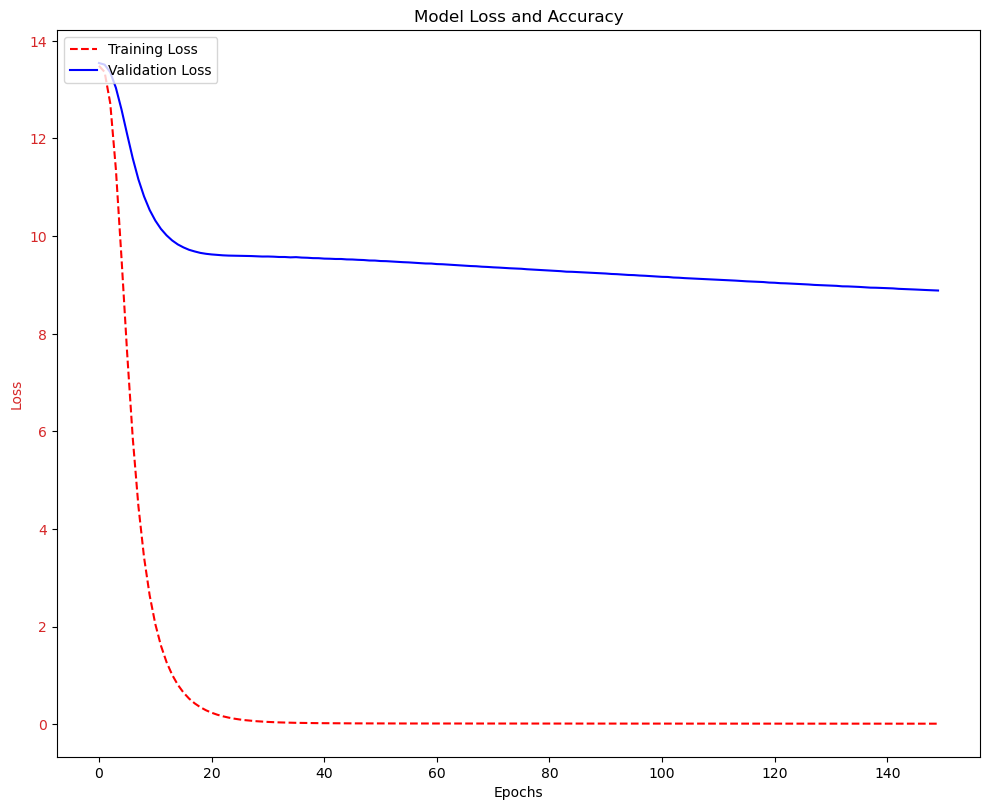

1250/1250 [==============================] - 4s 3ms/step
RMSE: 2.98058042111432
MAE: 2.5313239955037803
MAPE: 74.41168138342363
MSE: 8.883859646730016
R2 Score: -6.890193660420645


In [75]:
history_mda1 = train_model(model_a1, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda1)
# Llamar a la función para calcular métricas
calcular_metricas(model_a1, [x_test['userId'], x_test['movieId']], y_test)

# A2

Epoch 1/150
1250/1250 [==============================] - 16s 11ms/step - loss: 1.9477 - val_loss: 1.1324
Epoch 2/150
1250/1250 [==============================] - 14s 11ms/step - loss: 1.2141 - val_loss: 1.1359
Epoch 3/150
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0985 - val_loss: 1.1717
Epoch 4/150
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9687 - val_loss: 1.2057
Epoch 4: early stopping


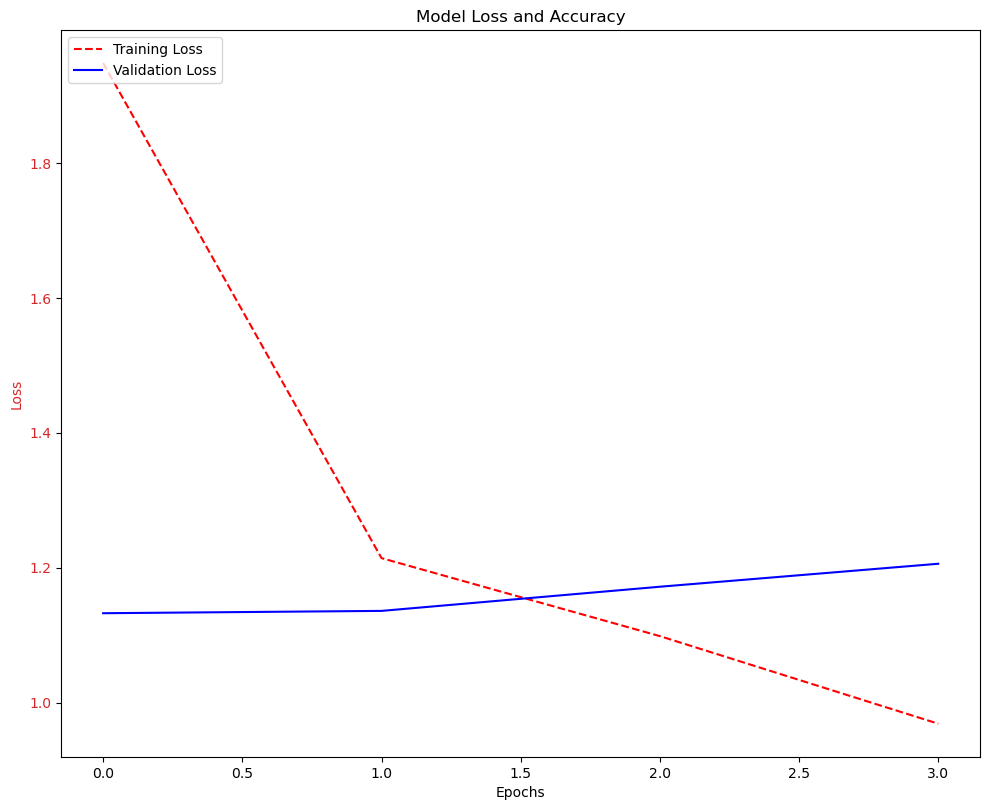

1250/1250 [==============================] - 4s 3ms/step
RMSE: 1.098056716644737
MAE: 0.8815044796466828
MAPE: 39.5246499983006
MSE: 1.2057285529686204
R2 Score: -0.07086696133508608


In [76]:
history_mda2 = train_model(model_a2, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda2)
calcular_metricas(model_a2, [x_test['userId'], x_test['movieId']], y_test)

# A3

Epoch 1/150
1250/1250 [==============================] - 16s 11ms/step - loss: 2.7384 - accuracy: 0.0287 - val_loss: 0.9621 - val_accuracy: 0.0318
Epoch 2/150
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0510 - accuracy: 0.0311 - val_loss: 0.9355 - val_accuracy: 0.0318
Epoch 3/150
1250/1250 [==============================] - 13s 11ms/step - loss: 0.8893 - accuracy: 0.0311 - val_loss: 0.9648 - val_accuracy: 0.0318
Epoch 4/150
1250/1250 [==============================] - 13s 10ms/step - loss: 0.7947 - accuracy: 0.0311 - val_loss: 0.9838 - val_accuracy: 0.0318
Epoch 5/150
1250/1250 [==============================] - 13s 11ms/step - loss: 0.7218 - accuracy: 0.0310 - val_loss: 1.0000 - val_accuracy: 0.0318
Epoch 5: early stopping


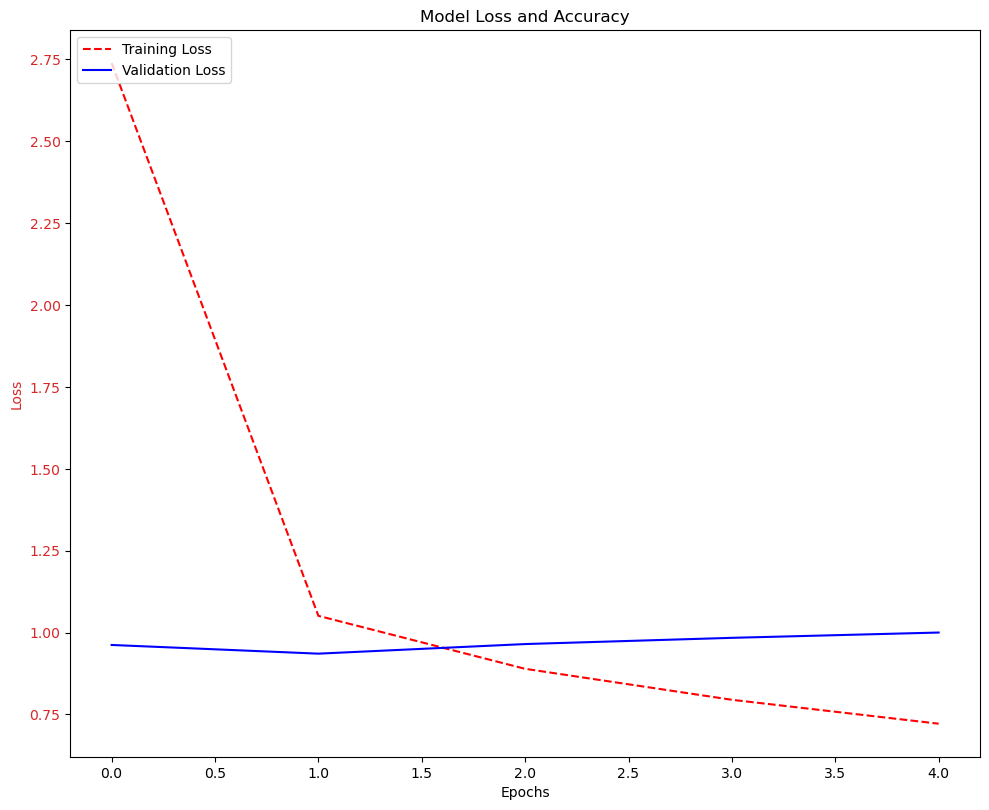

1250/1250 [==============================] - 4s 3ms/step
RMSE: 0.9999936686099244
MAE: 0.7781256875127553
MAPE: 33.28106631346815
MSE: 0.9999873372599355
R2 Score: 0.11186195384643882


In [77]:
history_mda3 = train_model(model_a3, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda3)
calcular_metricas(model_a3, [x_test['userId'], x_test['movieId']], y_test)

# A4

Epoch 1/150
1250/1250 [==============================] - 14s 10ms/step - loss: 13.4856 - val_loss: 13.5424
Epoch 2/150
1250/1250 [==============================] - 12s 9ms/step - loss: 13.3545 - val_loss: 13.5022
Epoch 3/150
1250/1250 [==============================] - 12s 10ms/step - loss: 12.6870 - val_loss: 13.3090
Epoch 4/150
1250/1250 [==============================] - 12s 10ms/step - loss: 11.2884 - val_loss: 12.9189
Epoch 5/150
1250/1250 [==============================] - 12s 9ms/step - loss: 9.4094 - val_loss: 12.3762
Epoch 6/150
1250/1250 [==============================] - 12s 10ms/step - loss: 7.4296 - val_loss: 11.7671
Epoch 7/150
1250/1250 [==============================] - 12s 10ms/step - loss: 5.6758 - val_loss: 11.1904
Epoch 8/150
1250/1250 [==============================] - 12s 10ms/step - loss: 4.2949 - val_loss: 10.7011
Epoch 9/150
1250/1250 [==============================] - 12s 10ms/step - loss: 3.2629 - val_loss: 10.3167
Epoch 10/150
1250/1250 [====================

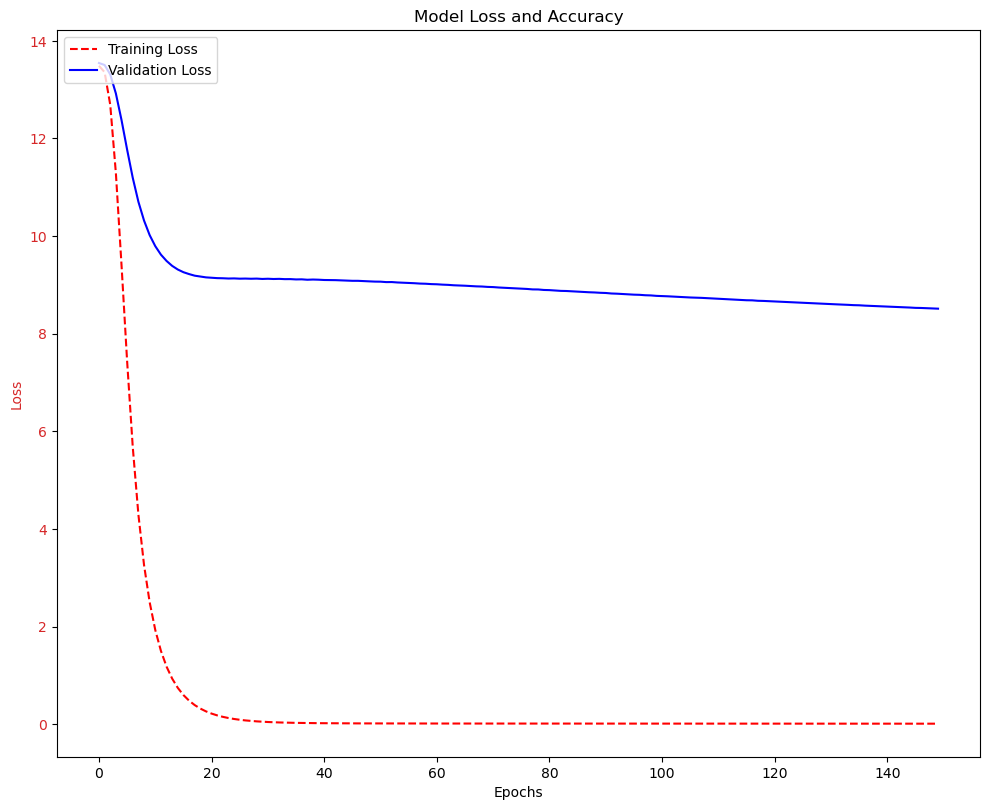

1250/1250 [==============================] - 4s 3ms/step
RMSE: 2.917503024404574
MAE: 2.465536440476465
MAPE: 72.77262977298
MSE: 8.511823897409835
R2 Score: -6.559770372855942


In [78]:
history_mda4 = train_model(model_a4, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda4)
calcular_metricas(model_a4, [x_test['userId'], x_test['movieId']], y_test)

# A5

Epoch 1/150
1250/1250 [==============================] - 16s 11ms/step - loss: 1.2316 - val_loss: 0.9137
Epoch 2/150
1250/1250 [==============================] - 12s 10ms/step - loss: 0.7309 - val_loss: 0.9102
Epoch 3/150
1250/1250 [==============================] - 12s 10ms/step - loss: 0.5791 - val_loss: 0.9744
Epoch 4/150
1250/1250 [==============================] - 13s 10ms/step - loss: 0.4653 - val_loss: 1.0569
Epoch 5/150
1250/1250 [==============================] - 13s 10ms/step - loss: 0.3608 - val_loss: 1.0709
Epoch 5: early stopping


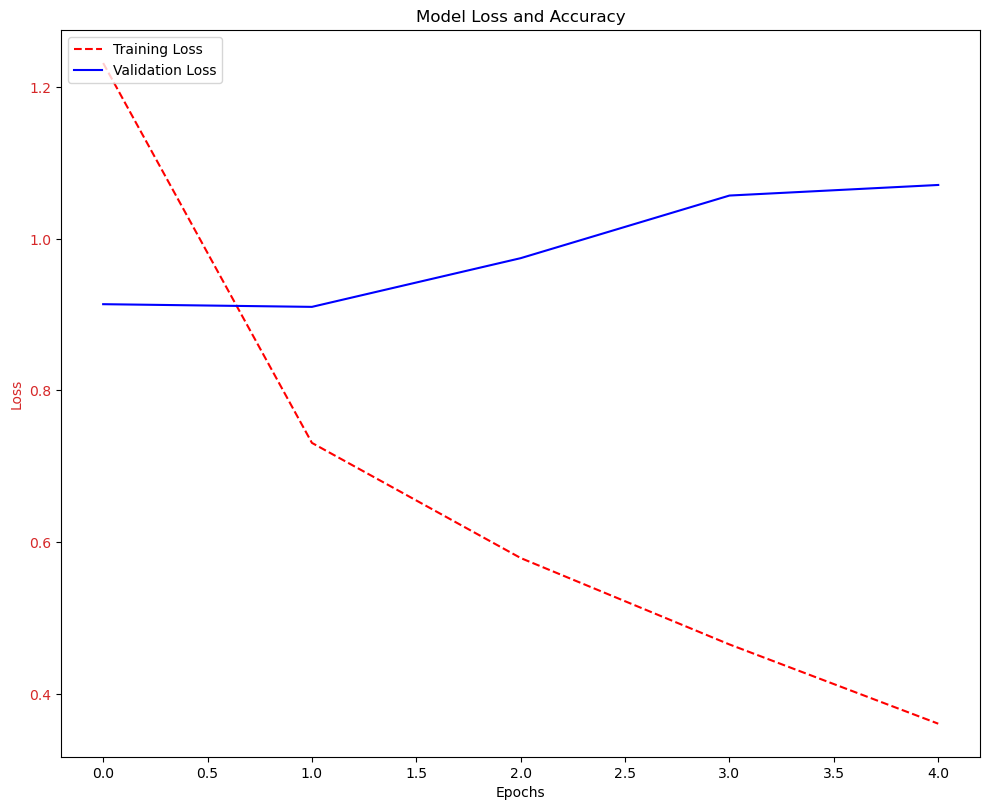

1250/1250 [==============================] - 4s 3ms/step
RMSE: 1.0348296214572084
MAE: 0.78962213588655
MAPE: 34.88688099462598
MSE: 1.070872345445269
R2 Score: 0.048905483973724184


In [79]:
history_mda5 = train_model(model_a5, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda5)
calcular_metricas(model_a5, [x_test['userId'], x_test['movieId']], y_test)

# A6

Epoch 1/150
1250/1250 [==============================] - 17s 11ms/step - loss: 12.4633 - val_loss: 11.4950
Epoch 2/150
1250/1250 [==============================] - 13s 11ms/step - loss: 10.3513 - val_loss: 9.6673
Epoch 3/150
1250/1250 [==============================] - 13s 10ms/step - loss: 8.1692 - val_loss: 8.0303
Epoch 4/150
1250/1250 [==============================] - 13s 10ms/step - loss: 5.9942 - val_loss: 6.6257
Epoch 5/150
1250/1250 [==============================] - 14s 11ms/step - loss: 4.1733 - val_loss: 5.5421
Epoch 6/150
1250/1250 [==============================] - 14s 11ms/step - loss: 2.8838 - val_loss: 4.7969
Epoch 7/150
1250/1250 [==============================] - 13s 10ms/step - loss: 2.0358 - val_loss: 4.3218
Epoch 8/150
1250/1250 [==============================] - 14s 11ms/step - loss: 1.4751 - val_loss: 4.0259
Epoch 9/150
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0926 - val_loss: 3.8459
Epoch 10/150
1250/1250 [============================

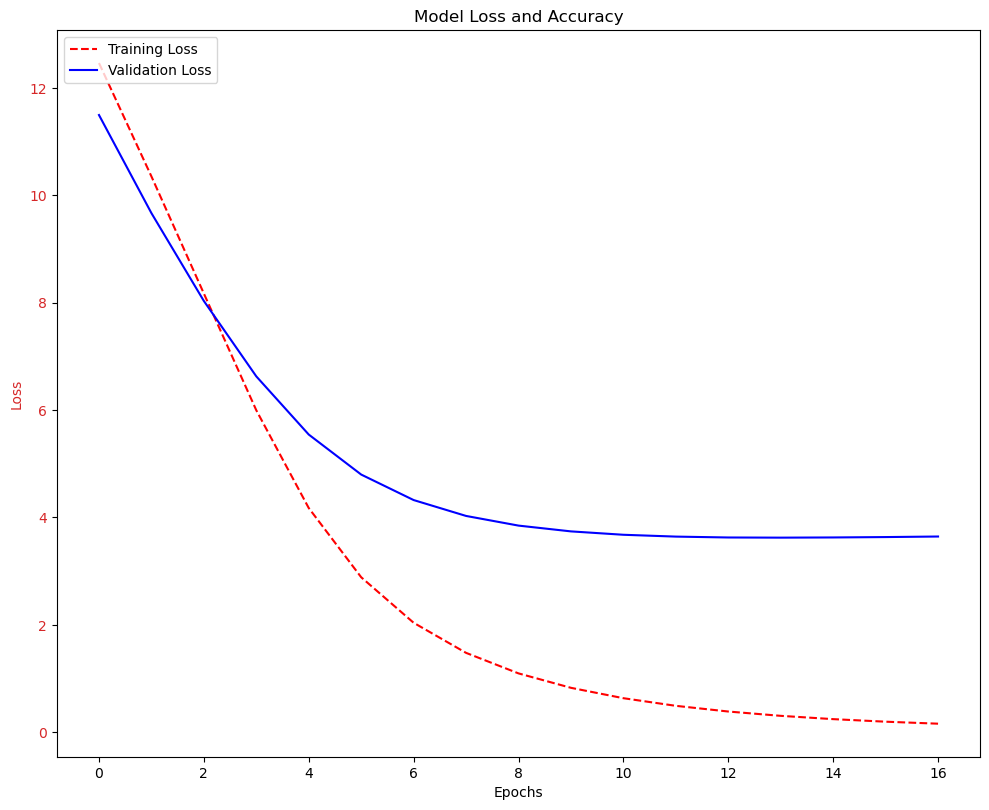

1250/1250 [==============================] - 4s 3ms/step
RMSE: 1.9085377738486147
MAE: 1.605288593353884
MAPE: 48.56876936693732
MSE: 3.642516434207026
R2 Score: -2.2350983941689146


In [80]:
history_mda6 = train_model(model_a6, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda6)
calcular_metricas(model_a6, [x_test['userId'], x_test['movieId']], y_test)

# A7

Epoch 1/150
1250/1250 [==============================] - 19s 13ms/step - loss: 7.7195 - val_loss: 7.4972
Epoch 2/150
1250/1250 [==============================] - 15s 12ms/step - loss: 7.4525 - val_loss: 7.4961
Epoch 3/150
1250/1250 [==============================] - 16s 13ms/step - loss: 7.4512 - val_loss: 7.4959
Epoch 4/150
1250/1250 [==============================] - 16s 12ms/step - loss: 7.4508 - val_loss: 7.4958
Epoch 5/150
1250/1250 [==============================] - 16s 13ms/step - loss: 7.4507 - val_loss: 7.4958
Epoch 6/150
1250/1250 [==============================] - 16s 13ms/step - loss: 7.4507 - val_loss: 7.4958
Epoch 7/150
1250/1250 [==============================] - 16s 12ms/step - loss: 7.4506 - val_loss: 7.4958
Epoch 8/150
1250/1250 [==============================] - 15s 12ms/step - loss: 7.4506 - val_loss: 7.4958
Epoch 9/150
1250/1250 [==============================] - 16s 13ms/step - loss: 7.4506 - val_loss: 7.4958
Epoch 10/150
1250/1250 [==============================]

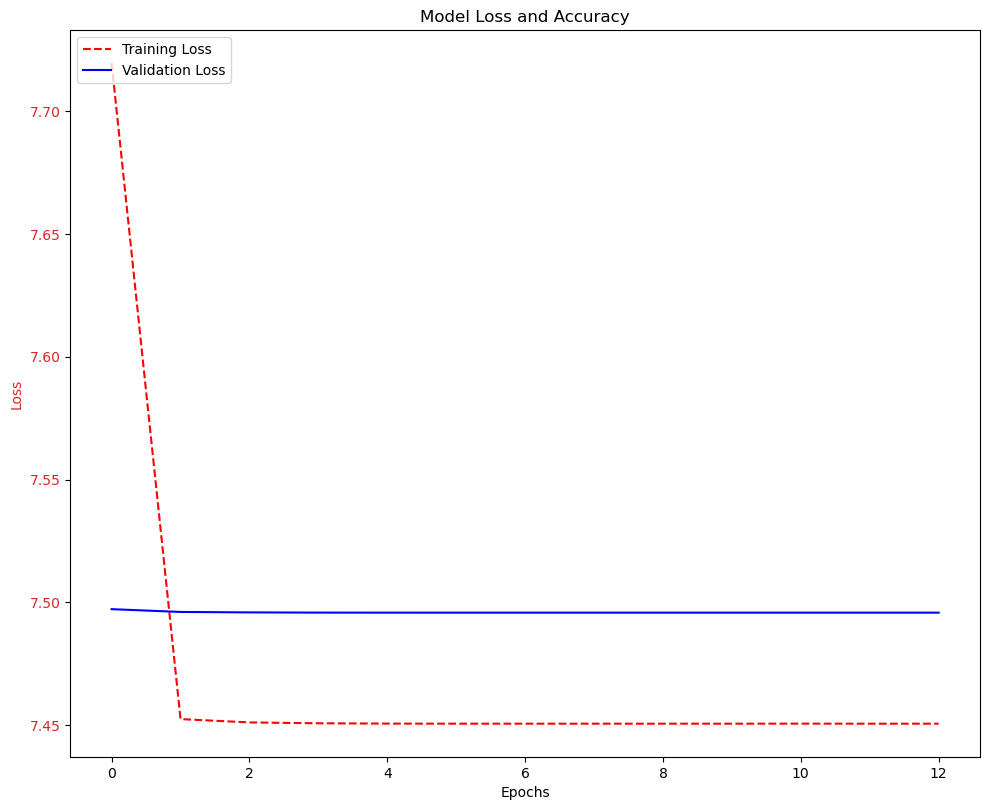

1250/1250 [==============================] - 5s 3ms/step
RMSE: 2.7378492942139054
MAE: 2.5400875015079976
MAPE: 68.80168853537911
MSE: 7.49581875782758
R2 Score: -5.657406126901489


In [81]:
history_mda7 = train_model(model_a7, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
plot_loss(history_mda7)
calcular_metricas(model_a7, [x_test['userId'], x_test['movieId']], y_test)

### Arquitectura 8

In [82]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [83]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Supongamos que tienes tus datos en las matrices 'usuarios', 'peliculas', 'generos' y 'calificaciones'
# 'usuarios', 'peliculas' y 'generos' son listas de IDs de usuarios, películas y géneros, respectivamente
# 'calificaciones' es una lista de calificaciones correspondientes a cada par usuario-película

# Convertir los datos de género a una lista de listas
generos_list = [generos.split('|') for generos in df_aux['genres']]

# Inicializar y ajustar el codificador one-hot
mlb = MultiLabelBinarizer()
generos_one_hot = mlb.fit_transform(generos_list)

#------------------------------------------------------------------------------
# # Asignar índices únicos a usuarios y películas
# user_unique_ids = df_aux['userId'].unique()
# movie_unique_ids = df_aux['movieId'].unique()

# userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
# movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# # Aplicar la asignación de índices únicos al DataFrame
# df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
# df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# # Dividir dataset en entrenamiento y test
# x_train, x_test, y_train, y_test = train_test_split(df_aux[['userId', 'movieId', 'genres']], df_aux['rating'], test_size=0.2, random_state=42)

# # Resetear los índices de x_train y x_test
# x_train.reset_index(drop=True, inplace=True)
# x_test.reset_index(drop=True, inplace=True)
#------------------------------------------------------------------------------

# Definir las capas de entrada
input_usuario = Input(shape=[1])
input_pelicula = Input(shape=[1])
input_genero = Input(shape=[generos_one_hot.shape[1]])  # Número de géneros únicos

# Definir las capas de embedding para usuarios y películas
embedding_usuario = Embedding(input_dim=len(user_unique_ids), output_dim=50)(input_usuario)
embedding_pelicula = Embedding(input_dim=len(movie_unique_ids), output_dim=50)(input_pelicula)

# Aplanar las capas de embedding
flat_usuario = Flatten()(embedding_usuario)
flat_pelicula = Flatten()(embedding_pelicula)

# Concatenar las capas de embedding con los géneros codificados one-hot
concat = Concatenate()([flat_usuario, flat_pelicula, input_genero])

# Agregar capas densas
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1)(dense2)

# Compilar el modelo
modelo_a8 = Model(inputs=[input_usuario, input_pelicula, input_genero], outputs=output)
# Generar la codificación one-hot de los géneros solo para las filas relevantes
generos_one_hot_train = generos_one_hot[x_train.index]
generos_one_hot_test = generos_one_hot[x_test.index]

# Compilar el modelo
modelo_a8.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelo_a8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        3485850     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        674600      ['input_2[0][0]']                
                                                                                              

Epoch 1/150
1250/1250 [==============================] - 50s 38ms/step - loss: 1.1845 - mae: 0.8269 - val_loss: 0.9226 - val_mae: 0.7440
Epoch 2/150
1250/1250 [==============================] - 52s 41ms/step - loss: 0.6482 - mae: 0.6097 - val_loss: 0.9562 - val_mae: 0.7573
Epoch 3/150
1250/1250 [==============================] - 50s 40ms/step - loss: 0.3476 - mae: 0.4366 - val_loss: 1.0482 - val_mae: 0.7955
Epoch 4/150
1250/1250 [==============================] - 56s 45ms/step - loss: 0.2019 - mae: 0.3363 - val_loss: 1.0656 - val_mae: 0.7976
Epoch 4: early stopping


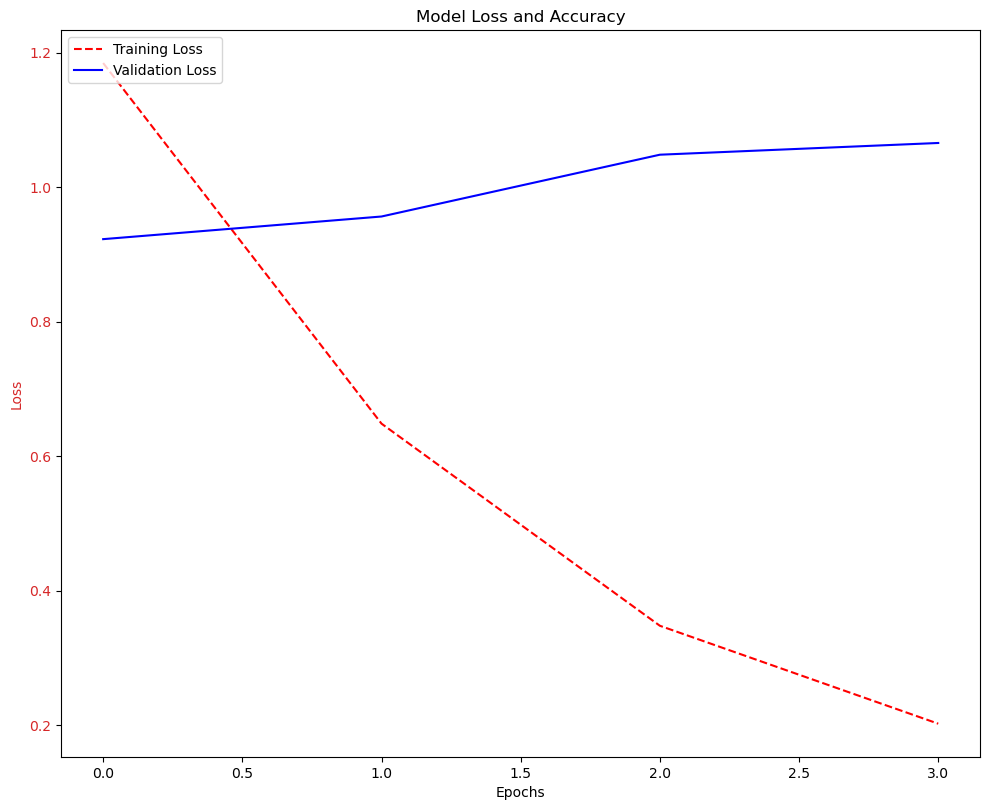

1250/1250 [==============================] - 3s 2ms/step
RMSE: 1.0322797272412132
MAE: 0.7976229516686871
MAPE: 35.237513934893975
MSE: 1.0656014352731933
R2 Score: 0.0535868391141856


In [84]:
# history_mda8 = modelo_a8.fit([x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, epochs=10, batch_size=128, validation_data=([x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test))
history_mda8 = train_model(modelo_a8, [x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, [x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test)
plot_loss(history_mda8)
calcular_metricas(modelo_a8, [x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test)

# Model Evaluation

Intentamos medir el rendimiento del modelo proporcionando productos candidatos al modelo y evaluando los resultados. Los productos candidatos se combinan con 49 productos seleccionados entre los productos no comprados y un producto objetivo representado en la variable output_sequence. Si el producto objetivo aparece en los k primeros resultados del modelo, lo consideramos un acierto.

Por otro lado; Hidasi y Karatzoglou (2018) definen "recall@k" como una métrica de evaluación como "la proporción de casos que tienen el elemento deseado entre los primeros k elementos en todos los casos de prueba." Además, otra métrica de evaluación es "MRR@k", que es la media de los rangos recíprocos de los ítems objetivo. El rango recíproco se fija en cero si el rango es superior a k.